In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath('../src'))

from preprocessing.cleaning import clean_telecom_data
from models.evaluation import evaluate_model_performance
from utils.helpers import save_model_artifact

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

print("Libraries and modular scripts loaded successfully!")

Libraries and modular scripts loaded successfully!


In [ ]:
raw_df = pd.read_csv('../data/raw/data.csv')

df = clean_telecom_data(raw_df)

le = LabelEncoder()
df['Churn'] = le.fit_transform(df['Churn'])
df = pd.get_dummies(df, drop_first=True)

X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Preprocessing complete using modular src scripts.")

Preprocessing complete using modular src scripts.


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    acc = model.score(X_test_scaled, y_test)
    print(f"{name} Accuracy: {acc:.4f}")

Logistic Regression Accuracy: 0.8088
SVM Accuracy: 0.7937
KNN Accuracy: 0.7492
Random Forest Accuracy: 0.7899


In [ ]:
best_xgb = XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    eval_metric='logloss',
    random_state=42
)

best_xgb.fit(X_train_scaled, y_train)
print("Optimized XGBoost trained successfully.")

Optimized XGBoost trained successfully.


In [ ]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

final_model = XGBClassifier(eval_metric='logloss', random_state=42)
final_model.fit(X_train_res, y_train_res)

print("Final Balanced Model (SMOTE) training complete.")

Final Balanced Model (SMOTE) training complete.


Final Model Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1552
           1       0.58      0.58      0.58       561

    accuracy                           0.78      2113
   macro avg       0.71      0.71      0.71      2113
weighted avg       0.78      0.78      0.78      2113



<Figure size 800x600 with 0 Axes>

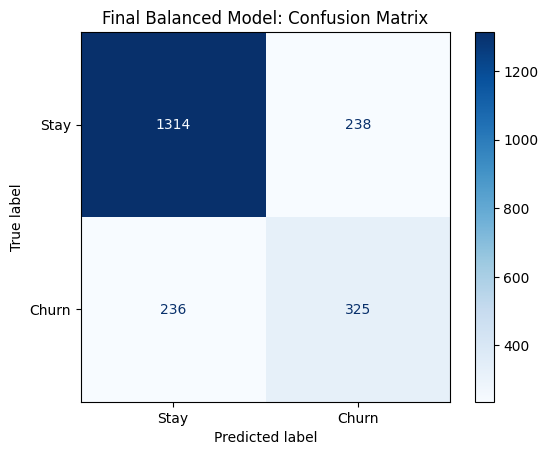

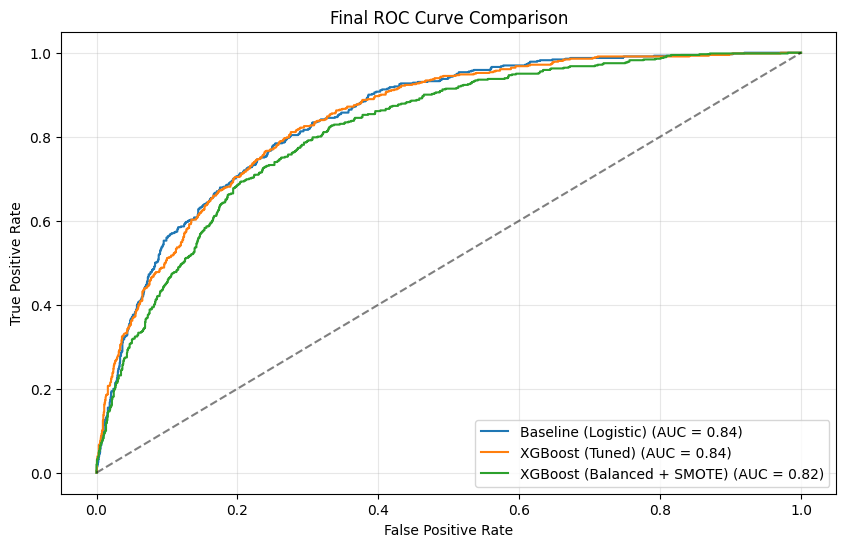


--- Generating SHAP Explainability Plot (Bonus) ---


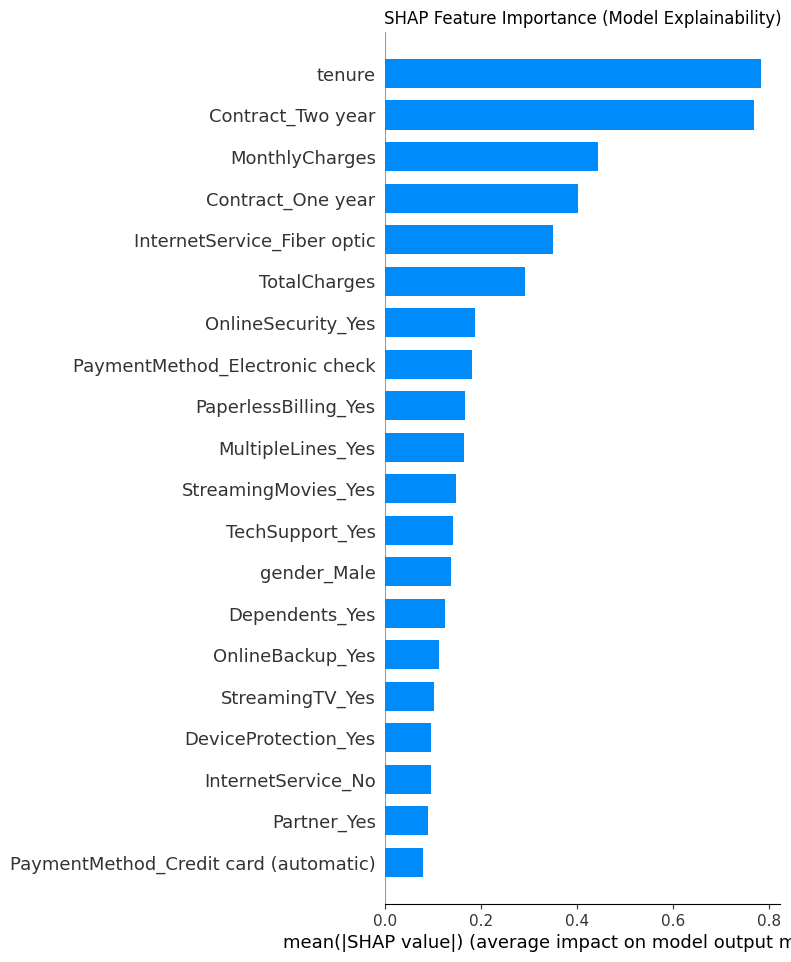

In [ ]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import shap


metrics = evaluate_model_performance(final_model, X_test_scaled, y_test)
print("Final Model Report:\n", metrics['report'])

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, final_model.predict(X_test_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Stay', 'Churn'])
disp.plot(cmap='Blues')
plt.title('Final Balanced Model: Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
all_models = [
    (models["Logistic Regression"], "Baseline (Logistic)"),
    (best_xgb, "XGBoost (Tuned)"),
    (final_model, "XGBoost (Balanced + SMOTE)")
]

for model, label in all_models:
    proba = model.predict_proba(X_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()


print("\n--- Generating SHAP Explainability Plot (Bonus) ---")
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_scaled)

plt.figure()
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("SHAP Feature Importance (Model Explainability)")
plt.show()

In [ ]:

final_pred = final_model.predict(X_test_scaled)

analysis_df = pd.DataFrame({'True_Label': y_test, 'Predicted_Label': final_pred}, index=y_test.index)

false_positives = X_test[(analysis_df['True_Label'] == 0) & (analysis_df['Predicted_Label'] == 1)].head(3)

false_negatives = X_test[(analysis_df['True_Label'] == 1) & (analysis_df['Predicted_Label'] == 0)].head(3)

print("--- ERROR ANALYSIS ---")
print("\n[False Positives] Predicted to CHURN, but actually STAYED:")
display(false_positives)

print("\n[False Negatives] Predicted to STAY, but actually CHURNED:")
display(false_negatives)


sample_index = 10
sample_row = X_test_scaled[sample_index].reshape(1, -1)
original_details = X_test.iloc[sample_index]

print("\n--- PROJECT DEMO: CUSTOMER PREDICTION ---")
print(f"Tenure: {original_details['tenure']} months")
print(f"Monthly Charges: ${original_details['MonthlyCharges']}")

is_m2m = "Yes" if original_details.get('Contract_One year', 0) == 0 and original_details.get('Contract_Two year',
                                                                                             0) == 0 else "No"
print(f"Month-to-Month Contract: {is_m2m}")

prediction = final_model.predict(sample_row)
probability = final_model.predict_proba(sample_row)[0][1]

status = "CHURN" if prediction[0] == 1 else "STAY"
print(f"\nRESULT: {status} (Churn Probability: {probability:.2%})")

save_model_artifact(final_model, 'final_churn_model.pkl')

--- ERROR ANALYSIS ---

[False Positives] Predicted to CHURN, but actually STAYED:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6060,1,8,87.10,713.60,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,True,False
2827,0,1,50.15,50.15,True,False,False,True,False,False,...,False,False,False,False,False,False,True,False,False,True
4515,0,15,83.20,1130.00,False,False,False,True,False,False,...,False,True,False,False,False,False,True,False,False,False



[False Negatives] Predicted to STAY, but actually CHURNED:


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6155,0,5,19.35,126.05,True,True,False,True,False,False,...,True,False,True,False,False,False,False,False,False,True
1244,0,15,19.40,289.30,False,False,False,True,False,False,...,True,False,True,False,False,False,False,False,False,False
5871,0,24,55.65,1400.55,True,False,False,True,False,True,...,False,False,False,False,False,False,True,False,False,False



--- PROJECT DEMO: CUSTOMER PREDICTION ---
Tenure: 62 months
Monthly Charges: $92.05
Month-to-Month Contract: No

RESULT: STAY (Churn Probability: 11.32%)
Model successfully saved to ../models\final_churn_model.pkl
